In [169]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import preprocessing
import numpy as np
import tensorflow as tf

In [170]:
ts = TimeSeries(key='AJH8MF4OQ465LD6H',output_format='pandas')
data, meta_data = ts.get_daily(symbol='REKR', outputsize='full')


In [171]:
#Remove date from data
data = data.reset_index()
data = data.drop('date', axis=1)
data

,1. open,2. high,3. low,4. close,5. volume
0,4.08,4.1720,3.890,3.93,85770.0
1,4.17,4.2461,4.020,4.14,51068.0
2,4.06,4.3100,4.015,4.30,78501.0
3,4.16,4.2000,3.880,4.01,105302.0
4,3.90,4.2100,3.810,4.11,87723.0
...,...,...,...,...,...
629,1.50,1.9500,0.510,0.51,2569.0
630,2.50,2.5000,1.400,1.98,4369.0
631,2.50,2.5000,2.500,2.50,586.0
632,3.00,3.0000,3.000,3.00,0.0


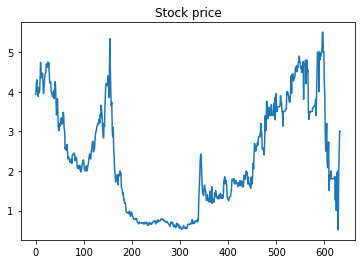

In [172]:
data['4. close'].plot()
plt.title('Stock price')
plt.show()

In [173]:
y=data['4. close']
X=data.drop(columns="4. close")

In [174]:
number_of_data = len(X) - 1

In [175]:
# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [177]:
# Create scaler instance
X_scaler = preprocessing.MinMaxScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


AttributeError: 'Series' object has no attribute 'reshape'

In [166]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  1024
hidden_nodes_layer2 = 512
hidden_nodes_layer3 =  256
hidden_nodes_layer4 = 128

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Thrid hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

#Compile the sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer= "adam", metrics=["accuracy"])

#Train the model
fit_model =nn.fit(X_train_scaled, y_train.values, epochs=50)

# Check the structure of the model
nn.summary()

#Evaluate the model using test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test.values,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Train on 475 samples
Epoch 1/50
475/475 [==============================] - 1s 2ms/sample - loss: -5.1835 - accuracy: 0.0021
Epoch 2/50
475/475 [==============================] - 0s 257us/sample - loss: -120.7289 - accuracy: 0.0021
Epoch 3/50
475/475 [==============================] - 0s 276us/sample - loss: -1106.0312 - accuracy: 0.0021
Epoch 4/50
475/475 [==============================] - 0s 273us/sample - loss: -7033.6338 - accuracy: 0.0021
Epoch 5/50
475/475 [==============================] - 0s 251us/sample - loss: -30596.8609 - accuracy: 0.0021
Epoch 6/50
475/475 [==============================] - 0s 244us/sample - loss: -99864.2020 - accuracy: 0.0021
Epoch 7/50
475/475 [==============================] - 0s 259us/sample - loss: -278352.5545 - accuracy: 0.0021
Epoch 8/50
475/475 [==============================] - 0s 256us/sample - loss: -680752.8013 - accuracy: 0.0021
Epoch 9/50
475/475 [==============================] - 0s 259us/sample - loss: -1496097.5795 - accuracy: 0.0021
Epoc